In [9]:
import seaborn as sns
import requests
import pandas as pd
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import logging
# Disable verbose font lookup messages from matplotlib's font_manager
logging.getLogger('matplotlib.font_manager').disabled = True
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Scrape data

In [2]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120 Safari/537.36",
    "Referer": "https://www.dongchedi.com/"
}

def get_rank_data(offset=0, count=50, month="1000", new_energy_type="", rank_data_type=11):
    url = "https://www.dongchedi.com/motor/pc/car/rank_data"
    parameters = {
        'aid': "1839",
        'app_name': "auto_web_pc",
        'month': month,
        'count': count,
        'offset': offset,
        'new_energy_type': new_energy_type,
        'rank_data_type': rank_data_type
    }
    session = requests.Session()
    session.headers.update(HEADERS)
    try:
        response = session.get(url, params=parameters, timeout=10)
        data = response.json()
        return data
    except (ConnectionError, Timeout, TooManyRedirects) as e:
        print(e)
    
def crawl_rank(pages, page_size):
    results = []
    for i in range(pages):
        print(f"Scraping page {i+1} ranking data")
        try:
            j = get_rank_data(offset=i * page_size, count=page_size)
        except Exception as e:
            print(e)
            continue
        data_list = j.get("data", {}).get("list", [])
        if not data_list:
            break
        for car in data_list:
            results.append({
                "series_id": car.get("series_id"),
                "series_name": car.get("series_name"),
                "brand_name": car.get("brand_name"),
                "sub_brand_name": car.get("sub_brand_name"),
                "min_price": car.get("min_price"),
                "max_price": car.get("max_price"),
                "count": car.get("count"),
                "score": car.get("score"),
                "rank": car.get("rank"),
            })
        time.sleep(random.uniform(0.5, 1.5))
    return results

if __name__ == "__main__":
    data = crawl_rank(pages=20, page_size=50)
    df = pd.DataFrame(data)
    df.to_csv("dongchedi_rank_data.csv", index=False, encoding="utf-8-sig")
    print("save: dongchedi_rank_data.csv")

Scraping page 1 ranking data
Scraping page 2 ranking data
Scraping page 3 ranking data
Scraping page 4 ranking data
Scraping page 5 ranking data
Scraping page 6 ranking data
Scraping page 7 ranking data
Scraping page 8 ranking data
Scraping page 9 ranking data
Scraping page 10 ranking data
Scraping page 11 ranking data
Scraping page 12 ranking data
Scraping page 13 ranking data
Scraping page 14 ranking data
Scraping page 15 ranking data
Scraping page 16 ranking data
save: dongchedi_rank_data.csv


# Data Cleaning

In [3]:
df = pd.read_csv('dongchedi_rank_data.csv')
missing_count = df.isnull().sum()
total_rows = len(df)
missing_percent = (missing_count / total_rows) * 100
missing_report = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage(%)': missing_percent.round(2)
}).sort_values('Missing Count', ascending=False)
if missing_report['Missing Count'].sum() == 0:
    print("No missing values found in the dataset.")
else:
    print(missing_report[missing_report['Missing Count'] > 0])

numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    print(df[numeric_cols].describe())
else:
    print("No numeric fields")

categorical_cols = df.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    for col in categorical_cols:
        print(f"\n{col} (Unique values count: {df[col].nunique()})")  #Identify high-cardinality vs low-cardinality variables
        print(f"Top 5 values: {df[col].value_counts().head()}")
else:
    print("No categorical variables")

print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")

if len(numeric_cols) > 0:
    for col in numeric_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr #Tukey’s fences
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        print(f"line:{col}")
        print(f"scope: [{df[col].min():.2f}, {df[col].max():.2f}]")
        print(f"median: {df[col].median():.2f}")
        print(f"Number of outliers: {outliers} ({outliers/len(df)*100:.2f}%)")

df = df.drop(columns=['score']) #Delete columns with no data
for col in ['min_price', 'max_price', 'count', 'rank']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

for col in ['series_name', 'brand_name', 'sub_brand_name']:
    df[col] = df[col].str.strip()

df = df.reset_index(drop=True)
df.to_csv("dongchedi_rank_data_cleaned.csv", index=False, encoding="utf-8-sig")

No missing values found in the dataset.
          series_id   min_price   max_price          count  score        rank
count    747.000000  747.000000  747.000000     747.000000  747.0  747.000000
mean    7974.485944   17.881673   23.627758   32457.574297    0.0  374.000000
std     7553.356529   29.669112   32.472413   56992.226056    0.0  215.784615
min       31.000000    0.000000    0.000000       1.000000    0.0    1.000000
25%     3182.000000    8.990000   12.875000    1697.500000    0.0  187.500000
50%     5461.000000   13.380000   17.980000    8875.000000    0.0  374.000000
75%     9333.500000   19.980000   26.980000   35744.500000    0.0  560.500000
max    25741.000000  718.000000  758.000000  446119.000000    0.0  747.000000

series_name (Unique values count: 747)
Top 5 values: series_name
星愿            1
e:NP2 极湃2     1
红旗HQ9 PHEV    1
柯米克GT         1
腾势Z9 DM       1
Name: count, dtype: int64

brand_name (Unique values count: 122)
Top 5 values: brand_name
比亚迪     44
本田      28


# Visalize -- Analyze correlation between numeric variables

<function matplotlib.pyplot.show(close=None, block=None)>

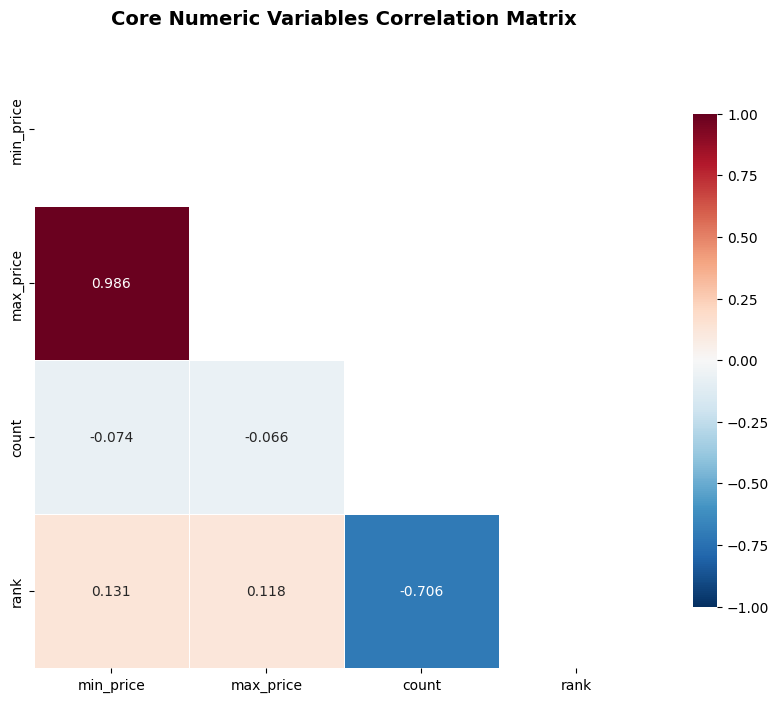

In [4]:
numeric_cols = ['min_price', 'max_price', 'count', 'rank']
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
cmap = plt.cm.RdBu_r
heatmap = sns.heatmap(correlation_matrix, 
                      mask=mask, 
                      cmap=cmap, 
                      annot=True, 
                      fmt='.3f',
                      linewidths=.5, 
                      cbar_kws={'shrink': .8}, 
                      vmin=-1, vmax=1)
plt.title('Core Numeric Variables Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.show

# Four-Quadrant Chart

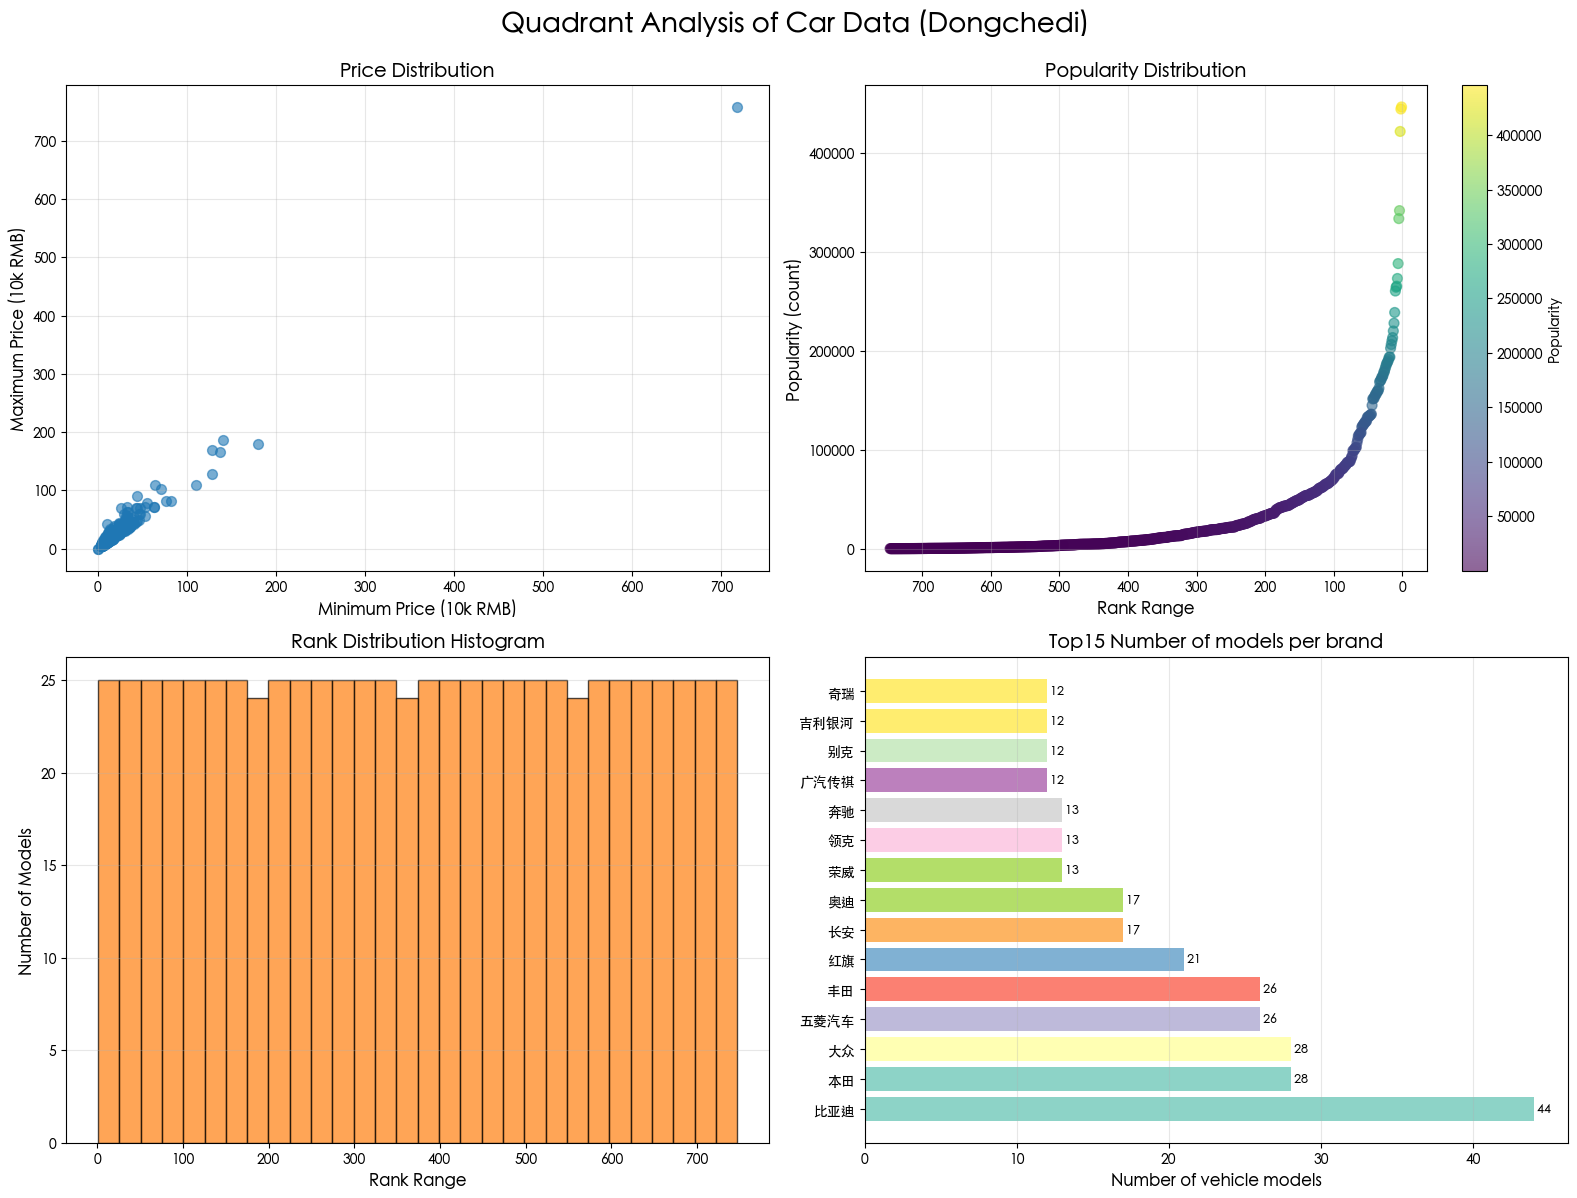

Basic Statistical Information on Data
Total number of vehicle models: 747
Number of brands: 122
Price range: 0.00 - 758.00 10k RMB
Average engagement: 32458
Highest level of attention: 446119

Top 5 Most Popular Vehicle Models:
  series_name brand_name   count  rank
0          星愿       吉利银河  446119     1
1  五菱宏光MINIEV       五菱汽车  443981     2
2     Model Y        特斯拉  421344     3
3          海鸥        比亚迪  341403     4
4          轩逸         日产  333308     5


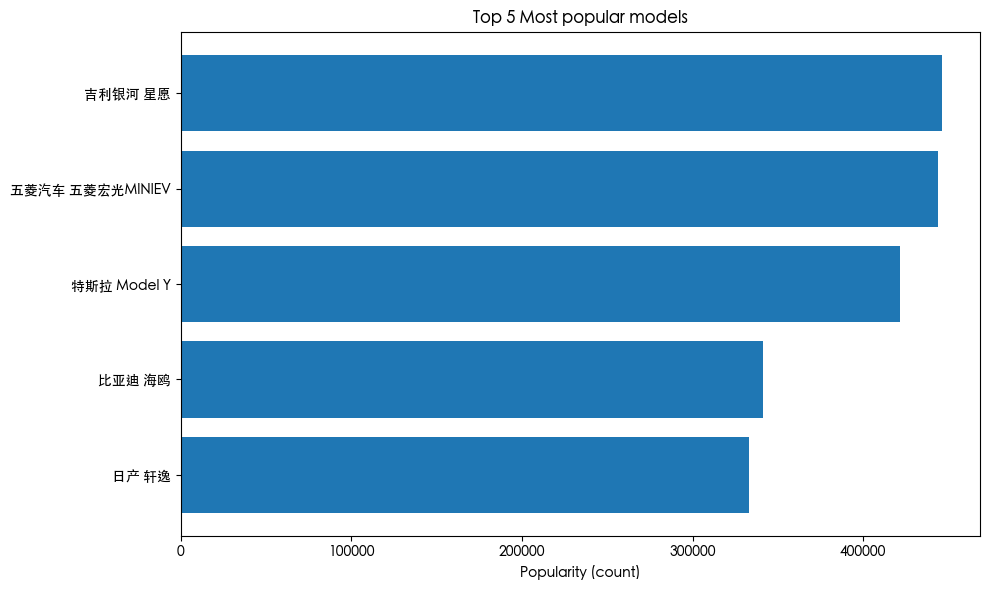

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Quadrant Analysis of Car Data (Dongchedi)', fontsize=20, fontweight='bold', y=0.995)
ax1 = axes[0, 0]
ax1.scatter(df['min_price'], df['max_price'], alpha=0.6, c='#1f77b4', s=50)
ax1.set_xlabel('Minimum Price (10k RMB)', fontsize=12)
ax1.set_ylabel('Maximum Price (10k RMB)', fontsize=12)
ax1.set_title('Price Distribution', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
scatter = ax2.scatter(df['rank'], df['count'], alpha=0.6, c=df['count'], 
                      cmap='viridis', s=50)
ax2.set_xlabel('Rank Range', fontsize=12)
ax2.set_ylabel('Popularity (count)', fontsize=12)
ax2.set_title('Popularity Distribution', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.invert_xaxis()  
plt.colorbar(scatter, ax=ax2, label='Popularity')

plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC", "Microsoft YaHei", "Arial Unicode MS"]
plt.rcParams['axes.unicode_minus'] = False
ax3 = axes[1, 0]
ax3.hist(df['rank'], bins=30, color='#ff7f0e', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Rank Range', fontsize=12)
ax3.set_ylabel('Number of Models', fontsize=12)
ax3.set_title('Rank Distribution Histogram', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

ax4 = axes[1, 1]
brand_counts = df['brand_name'].value_counts().head(15)
colors = plt.cm.Set3(np.linspace(0, 1, 15))
bars = ax4.barh(range(len(brand_counts)), brand_counts.values, color=colors)
ax4.set_yticks(range(len(brand_counts)))
ax4.set_yticklabels(brand_counts.index, fontsize=10)
ax4.set_xlabel('Number of vehicle models', fontsize=12)
ax4.set_title('Top15 Number of models per brand', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

for i, (bar, value) in enumerate(zip(bars, brand_counts.values)):
    ax4.text(value, i, f' {value}', va='center', fontsize=9)
plt.tight_layout()
plt.savefig('Automotive Data Quadrant Analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("=" * 50)
print("Basic Statistical Information on Data")
print("=" * 50)
print(f"Total number of vehicle models: {len(df)}")
print(f"Number of brands: {df['brand_name'].nunique()}")
print(f"Price range: {df['min_price'].min():.2f} - {df['max_price'].max():.2f} 10k RMB")
print(f"Average engagement: {df['count'].mean():.0f}")
print(f"Highest level of attention: {df['count'].max()}")
print("\nTop 5 Most Popular Vehicle Models:")
print(df.nlargest(5, 'count')[['series_name', 'brand_name', 'count', 'rank']])
top5 = df.nlargest(5, 'count')[['series_name', 'brand_name', 'count', 'rank']]
top5 = top5.sort_values('count', ascending=True)
labels = top5['brand_name'] + ' ' + top5['series_name']
plt.figure(figsize=(10, 6))
plt.barh(labels, top5['count'])
plt.xlabel('Popularity (count)')
plt.title('Top 5 Most popular models')
plt.tight_layout()
plt.show()

# Cluster

The volume of updated data：686
K Value：[2, 3, 4, 5, 6, 7]
coefficient：[0.39, 0.402, 0.367, 0.369, 0.351, 0.342]
Best K = 3
    min_price   count  rank  cluster brand_name
16      12.29  202441    17        0         大众
17       7.99  193600    18        0         奇瑞
18      23.55  193438    19        0        特斯拉
19       8.99  191062    20        0         长安
20       7.48  189063    21        0        比亚迪


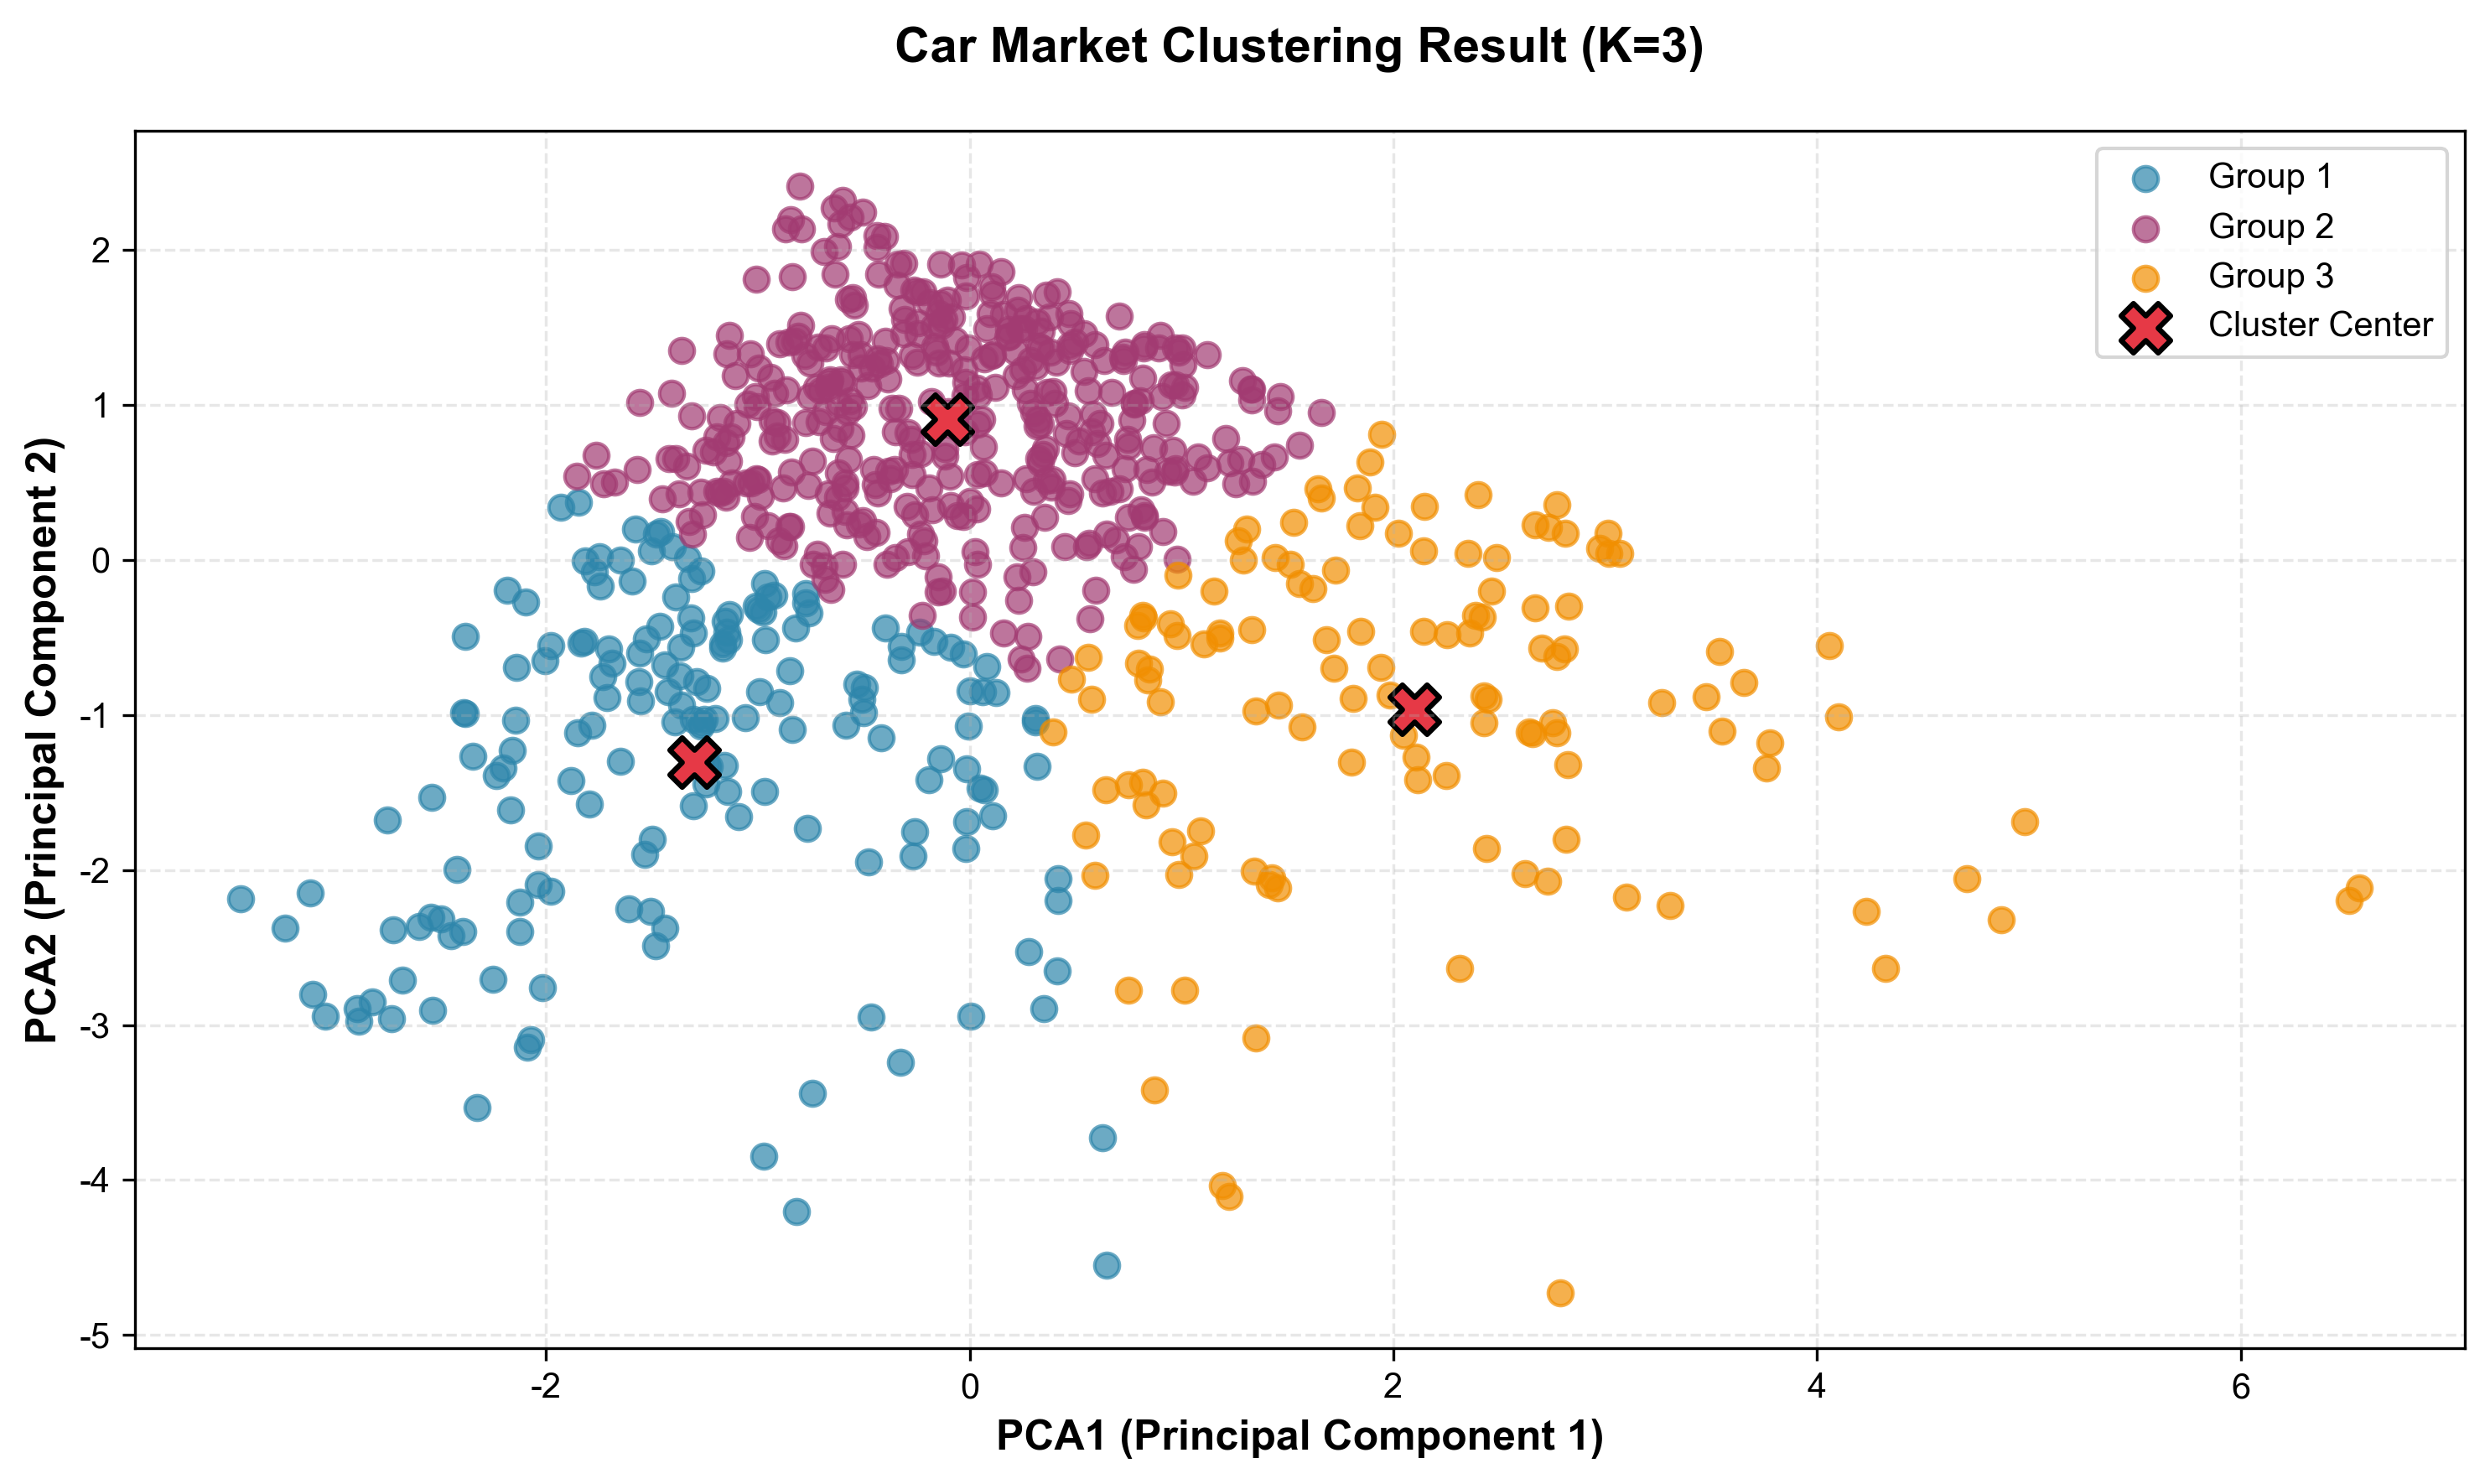

Result :
Group1：
  Number：174（25.364431486880466%）
  Price Range：12.6-17.712413793103448 Ten Thousand Yuan
  Attention：80158
  Hot brand：比亚迪(23款)、丰田(11款)、大众(9款)
  Feature：Low price，High attention
Group2：
  Number：385（56.12244897959183%）
  Price Range：12.5-16.86615584415584 Ten Thousand Yuan
  Attention：6659
  Hot brand：本田(21款)、五菱汽车(16款)、比亚迪(15款)
  Feature：Low price，Low attention
Group3：
  Number：127（18.513119533527696%）
  Price Range：30.5-39.951023622047245 Ten Thousand Yuan
  Attention：18910
  Hot brand：腾势(9款)、奥迪(8款)、蔚来(7款)
  Feature：Medium or High Price，High attention


In [11]:
# Data processing before cluster analysis
features = ['min_price', 'max_price', 'count', 'rank']
df_cluster = df[features].copy()

# Handle extreme values
def remove_outliers(df, cols, percent =0.01):
    df_processed = df.copy()
    for col in cols:
        low = df_processed[col].quantile(percent)
        high = df_processed[col].quantile(1 - percent)
        df_processed = df_processed[(df_processed[col] >= low) & (df_processed[col] <= high)]
    return df_processed
df_outliers = remove_outliers(df_cluster, features, percent = 0.01)
print(f"The volume of updated data：{len(df_outliers)}")

# standardization
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_outliers)
df_scaled = pd.DataFrame(df_scaled, columns= features)

# Best number for clusters K
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
k_range = range(2, 8)
sil_scores = []
best_score = -1
best_k = None
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    sil_scores.append(score)
    if score > best_score:
        best_score = score
        best_k = k
print(f"K Value：{list(k_range)}")
print(f"coefficient：{[round(s, 3) for s in sil_scores]}")
print(f"Best K = {best_k}")

final_k = 3
kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(df_scaled)
df_result = df_outliers.copy()
df_result['cluster'] = labels
df_result['brand_name'] = df.loc[df_outliers.index, 'brand_name']
print(df_result[['min_price', 'count', 'rank', 'cluster', 'brand_name']].head())

# PCA initialization and data transformation
pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
df_pca['cluster'] = labels
plt.rcParams['font.family'] = ['SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False
colors = ['#2E86AB', '#A23B72', '#F18F01', '#6A994E', '#E63946', '#F72585']
colors = colors[:final_k]
plt.figure(figsize=(10, 6), dpi=300)

for i in range(final_k):
    cluster_data = df_pca[df_pca['cluster'] == i]
    plt.scatter(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        color=colors[i],
        label=f'Group {i+1}',
        alpha=0.7,
        s=50  
    )
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    x=centers_pca[:, 0],
    y=centers_pca[:, 1],
    color='#E63946',
    marker='X',
    s=200,
    edgecolors='black',
    linewidth=1.5,
    label='Cluster Center'
)
plt.xlabel('PCA1 (Principal Component 1)', fontsize=12, fontweight='bold')
plt.ylabel('PCA2 (Principal Component 2)', fontsize=12, fontweight='bold')
plt.title(f'Car Market Clustering Result (K={final_k})', fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.3, linestyle='--')  
plt.tight_layout()
plt.show()


print(f"Result :")
group_centers = scaler.inverse_transform(kmeans.cluster_centers_)
for group_num in range(final_k):
    car_count = len(df_result[df_result['cluster'] == group_num])
    percentage = (car_count / len(df_result)) * 100
    min_P = group_centers[group_num][0]
    max_P = group_centers[group_num][1]
    count = group_centers[group_num][2]
    rank = group_centers[group_num][3]
    top_b = df_result[df_result['cluster'] == group_num]['brand_name'].value_counts().head(3)
    brands_str = "、".join([f"{b}({c}款)" for b, c in top_b.items()]) if len(top_b) > 0 else "无"
    price_desc = "Low price" if min_P < 15 else "Medium or High Price"
    focus_desc = "High attention" if count > 10000 else "Low attention"
    print(f"Group{group_num+1}：")
    print(f"  Number：{car_count}（{percentage:}%）")
    print(f"  Price Range：{min_P:.1f}-{max_P:} Ten Thousand Yuan")
    print(f"  Attention：{count:.0f}")
    print(f"  Hot brand：{brands_str}")
    print(f"  Feature：{price_desc}，{focus_desc}")

# Decision Tree


Best Depth Found: 2, Test Acc = 0.560
Evaluation Results (max_depth=2)
Test set accuracy: 0.56

Confusion Matrix:
[[90 23]
 [76 36]]

Classification Report:
                precision    recall  f1-score   support

 Low Attention       0.54      0.80      0.65       113
High Attention       0.61      0.32      0.42       112

      accuracy                           0.56       225
     macro avg       0.58      0.56      0.53       225
  weighted avg       0.58      0.56      0.53       225



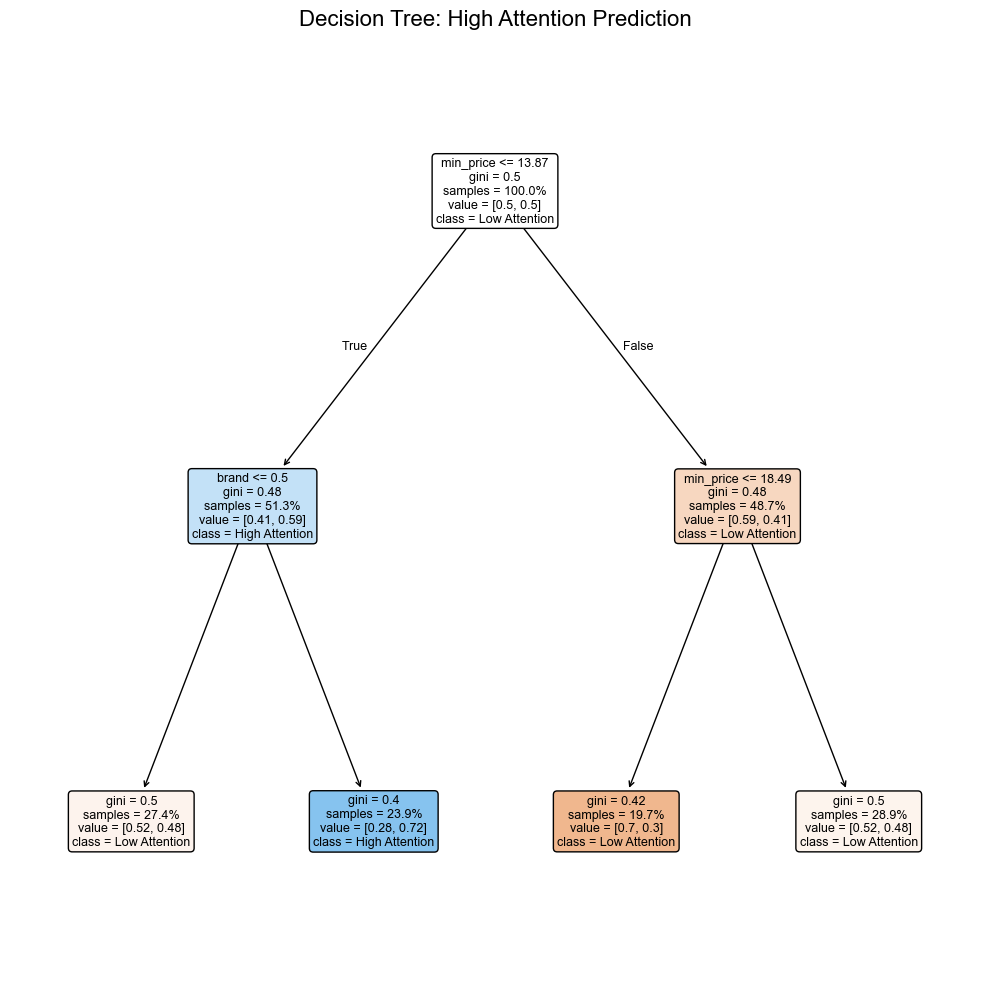


High-Attention Vehicle Model Rules (max_depth=2:
Lowest price <= 13.9ten thousand,Brand is in ['other_brand'] , -> Low Attention(Coverage ratio:52.4%)
Lowest price <= 13.9ten thousand,Brand is in ['吉利银河', '五菱汽车', '比亚迪', '日产', '大众', '丰田', '奇瑞', '长安', '本田', '奥迪', '红旗', '奔驰', '别克', '荣威', '广汽传祺', '领克', '福特', '起亚', '星途', '大通'], -> High Attention(Coverage ratio:72.0%)
Lowest price > 13.9ten thousand,Lowest price <= 18.5ten thousand, -> Low Attention(Coverage ratio:69.9%)
Lowest price > 13.9ten thousand,Lowest price > 18.5ten thousand, -> Low Attention(Coverage ratio:52.3%)

Feature Importance:
brand : 0.387
min_price : 0.613


In [14]:
# 1. Data Reading and Data Preprocessing
data = pd.read_csv("dongchedi_rank_data_cleaned.csv")
# Counts exceeding the median are marked as high priority (1), low priority (0).
median_count = data["count"].median()
data["high_attention"] = (data["count"] > median_count).astype(int)
feature_data = data[["brand_name", "min_price"]].copy()
target = data["high_attention"]

# 2. Brand Code
brand_count = data["brand_name"].value_counts()
big_brands = brand_count[brand_count >= 10].index.tolist()
def handle_brand(x):
    if x in big_brands:
        return x
    else:
        return "other_brand"
feature_data["brand_simple"] = feature_data["brand_name"].apply(handle_brand)
brand_encoder = LabelEncoder()
feature_data["brand_code"] = brand_encoder.fit_transform(feature_data["brand_simple"])
final_features = feature_data[["brand_code", "min_price"]]
feature_names = ["brand", "min_price"]
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    final_features, target, test_size=0.3, random_state=42, stratify=target)

# 3. Train decision tree models
best_depth = None
best_test_acc = 0
search_results = []
for depth in range(2, 5):
    model = DecisionTreeClassifier(max_depth=depth, min_samples_split=20,
                                   min_samples_leaf=10, criterion="gini", random_state=42)
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    search_results.append((depth, train_acc, test_acc))
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_depth = depth
        tree_model = model
print(f"\nBest Depth Found: {best_depth}, Test Acc = {best_test_acc:.3f}")

# 4. Model Prediction and Evaluation
y_predict = tree_model.predict(X_test)
print(f"Evaluation Results (max_depth={best_depth})")
print("Test set accuracy:", round(accuracy_score(y_test, y_predict), 3))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_predict))
print("\nClassification Report:")
print(classification_report(y_test, y_predict, target_names=["Low Attention", "High Attention"]))

# 5. Visualization
plt.figure(figsize=(10, 10))
plot_tree(
    tree_model,
    feature_names=feature_names,
    class_names=["Low Attention", "High Attention"],
    filled=True,
    rounded=True,
    fontsize=9,
    proportion=True,
    precision=2
)
plt.title("Decision Tree: High Attention Prediction", fontsize=16)
plt.tight_layout()
plt.show()

# 6. Extraction Rules
brand_dict = dict(zip(feature_data["brand_code"], feature_data["brand_simple"]))
# Variables required for extracting the tree structure
tree = tree_model.tree_
tree_feat = tree.feature
tree_thresh = tree.threshold
left_child = tree.children_left
right_child = tree.children_right
node_value = tree.value
node_class = tree_model.classes_
rule_list = []
#Using Recursion to Traverse Trees
def get_rules(node, rule_text=""):
    if left_child[node] == right_child[node]:
        cls = np.argmax(node_value[node][0])
        cls_name = "High Attention" if node_class[cls] == 1 else "Low Attention"
        ratio = node_value[node][0][cls] / sum(node_value[node][0])
        rule_list.append(f"{rule_text} -> {cls_name}(Coverage ratio:{ratio:.1%})")
        return
    feat_id = tree_feat[node]
    threshold = tree_thresh[node]
    feat_name = feature_names[feat_id]
    if feat_name == "brand":
        left_brands = [brand_dict[i] for i in brand_dict if i <= threshold]
        left_rule = rule_text + f"Brand is in {left_brands} ,"
    else: left_rule = rule_text + f"Lowest price <= {threshold:.1f}ten thousand,"
    get_rules(left_child[node], left_rule)
    if feat_name == "brand":
        right_brands = [brand_dict[i] for i in brand_dict if i > threshold]
        right_rule = rule_text + f"Brand is in {right_brands},"
    else: right_rule = rule_text + f"Lowest price > {threshold:.1f}ten thousand,"
    get_rules(right_child[node], right_rule)
get_rules(0)
print(f"\nHigh-Attention Vehicle Model Rules (max_depth={best_depth}:")
for r in rule_list:
    print(r)

# 7. Feature Importance
importance = tree_model.feature_importances_
print("\nFeature Importance:")
for i in range(len(feature_names)):
    print(feature_names[i], ":", round(importance[i], 3))

# 8. Output results
with open(f"high_attention_rules_depth{best_depth}.txt", "w", encoding="utf-8") as f:
    f.write(f"High-Interest Vehicle Decision Tree Rules (max_depth={best_depth})\n")
    f.write("Model accuracy:" + str(round(accuracy_score(y_test, y_predict), 3)) + "\n\n")
    for r in rule_list:
        f.write(r + "\n")
    f.write("\nFeature Importance:\n")
    for i in range(len(feature_names)):
        f.write(f"{feature_names[i]}: {importance[i]:.3f}\n")